In [1]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df_train=pd.read_csv('labeled_data.csv')

In [6]:
df_train.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
df_train.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [9]:
df_train.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [10]:
# No empty data..plus Id is there, which I don't need. So, I'm dropping it
df_train.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [11]:
df_train.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


#### Explaination about the data
Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users.

0 - hate speech
1 - offensive  language
2 - neither
tweet = raw tweet tex

#### Performing exploratory data analysis

In [12]:
hatespeech=df_train[df_train['class']==0]['class'].count()
class_other=df_train[df_train['class']!=0]['class'].count()

Text(0.5, 1.0, 'Class Distribution')

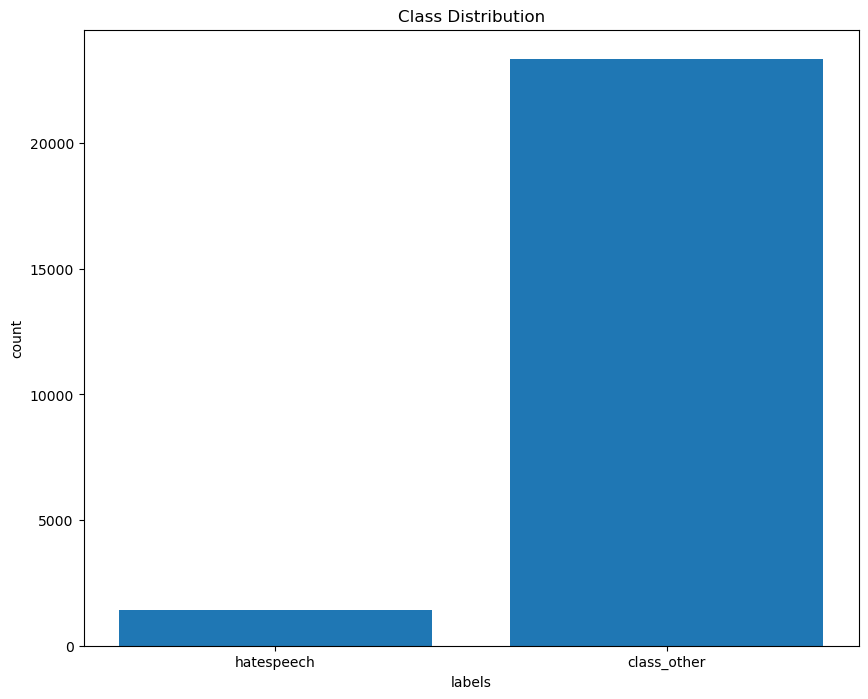

In [13]:
plt.figure(figsize=(10,8))
plt.bar(x=['hatespeech','class_other'],height=[hatespeech,class_other])
plt.xlabel('labels')
plt.ylabel('count')
plt.title('Class Distribution')

In [14]:
offensive_language=df_train[df_train['class']==1]['class'].count()
neither=df_train[df_train['class']==2]['class'].count()

Text(0.5, 1.0, 'Class Distribution')

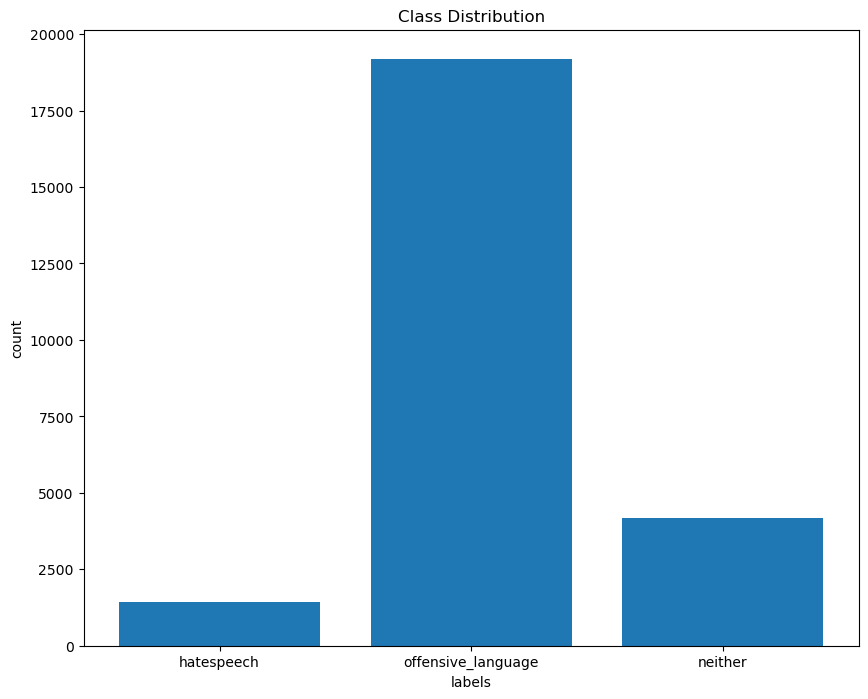

In [15]:
plt.figure(figsize=(10,8))
plt.bar(x=['hatespeech','offensive_language','neither'],height=[hatespeech,offensive_language,neither])
plt.xlabel('labels')
plt.ylabel('count')
plt.title('Class Distribution')

In [16]:
print(hatespeech,offensive_language,neither)

1430 19190 4163


#### Based on the following things I can make the following assumptions
1. The data is not evenly made. So there is some kind of weight balancing that I've to do
2. The data is in 3 labeles, but my project is not classification but detection. So I'll be changing the two categories of class labels of 2 and 1 to 0 and 0 to 1

In [17]:
df_train.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [18]:
df_train.loc[(df_train['class']== 1)|(df_train['class']==2),'class']=3


In [19]:
df_train.loc[(df_train['class']== 0),'class']=1

In [20]:
df_train.loc[(df_train['class']== 3),'class']=0

In [21]:
hatespeech=df_train[df_train['class']==1]['class'].count()
not_hatespeech=df_train[df_train['class']==0]['class'].count()

Text(0.5, 1.0, 'Class Distribution')

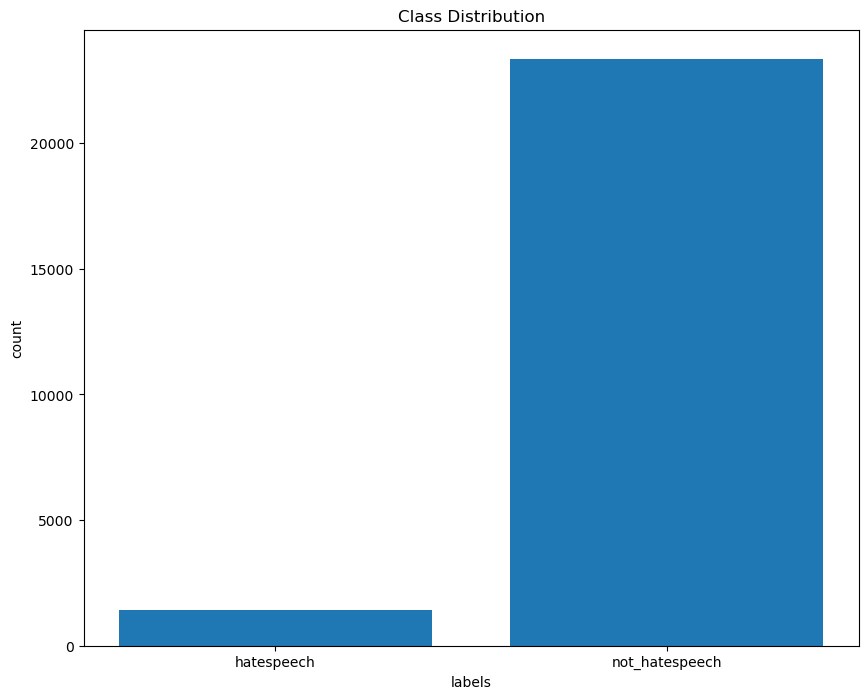

In [22]:
plt.figure(figsize=(10,8))
plt.bar(x=['hatespeech','not_hatespeech'],height=[hatespeech,not_hatespeech])
plt.xlabel('labels')
plt.ylabel('count')
plt.title('Class Distribution')

In [23]:
X=df_train['tweet']
y=df_train['class']

In [24]:
y.value_counts()

class
0    23353
1     1430
Name: count, dtype: int64

In [25]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(row):
    row = re.sub(r'@\w+', '', row)  # Remove user mentions
    row = re.sub(r'http\S+', '', row)  # Remove URLs
    row = row.lower()  # Lowercase
    row = re.sub(r'[^a-zA-Z\s]', '', row)  # Remove special characters and numbers
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'


In [26]:
def get_features(X_train,train_data=False):
    X=[]
    for row in X_train:
        row=preprocess(row)
        X.append(row)
    if(train_data==True):
        X_tfidf=tfidf.fit_transform(X)
    else:
        X_tfidf=tfidf.transform(X)
    return X_tfidf
    
        

In [27]:
def train_model(X_train,y_train,model):
    X=get_features(X_train,train_data=True)
    model.fit(X,y_train)
    return model

In [28]:
X_train,X_test,y_train,y_pred=train_test_split(X,y,test_size=0.2,train_size=0.8,stratify=y)
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2))
LR_model=LogisticRegression(random_state=42,max_iter=1000,class_weight='balanced',C=1)
model=train_model(X_train,y_train,LR_model)

In [29]:
def model_predict(trained_model,X_test,y_test):
    X=get_features(X_test,train_data=False)
    predictions=trained_model.predict(X)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm=confusion_matrix(y_test,predictions)
    # Print metrics for analysis
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(cm)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    print(tn, fp, fn, tp)

In [30]:
model_predict(model,X_test,y_pred)

Accuracy: 0.91
Precision: 0.35
Recall: 0.63
F1 Score: 0.45
[[4334  337]
 [ 105  181]]
4334 337 105 181


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, stratify=y)
nb=MultinomialNB()
model=train_model(X_train,y_train,nb)

In [32]:
model_predict(model,X_test,y_test)

Accuracy: 0.94
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
[[7006    0]
 [ 429    0]]
7006 0 429 0


C:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Using Smote Technique for OverSampling

In [33]:
!pip install scikit-learn
!pip install imbalanced-learn

In [37]:
!pip install scikit-learn==0.24.2
!pip install imbalanced-learn==0.8.0


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [59 lines of output]
  <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  Partial import of sklearn during the build process.
  <string>:116: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
  INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  Traceback (most recent call last):
    File "C:\Users\acer\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_proces


  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


### LR Result with TIFIDF and  without smote

In [38]:
X_train,X_test,y_train,y_pred=train_test_split(X,y,test_size=0.2,train_size=0.8)
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2))
LR_model=LogisticRegression(random_state=42,max_iter=1000,class_weight='balanced',C=1)
model=train_model(X_train,y_train,LR_model)

In [39]:
model_predict(model,X_test,y_pred)

Accuracy: 0.91
Precision: 0.36
Recall: 0.64
F1 Score: 0.46
[[4300  354]
 [ 108  195]]
4300 354 108 195


#### LR with tfidf and Smote

In [40]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2))
X_res, y_res = smote.fit_resample(get_features(X_train, train_data=True), y_train)
model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', C=1)
model.fit(X_res, y_res)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42)

In [41]:
model_predict(model,X_test,y_pred)

Accuracy: 0.92
Precision: 0.38
Recall: 0.60
F1 Score: 0.47
[[4362  292]
 [ 122  181]]
4362 292 122 181


## Working On LR with Word 2 vec without oversampling

In [42]:
import gensim.downloader

In [44]:
word2Vec = gensim.downloader.load('glove-twitter-200')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(row):
    row = row.lower()
    row = re.sub(r'[^\w\s]', '', row)
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'

        

In [45]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(row):
    row = row.lower()
    row = re.sub(r'[^\w\s]', '', row)
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'

        

In [46]:
def create_vector_with_word2vec(texts):
    training_vectors=[]
    for row in texts:
        row = preprocess(row)  # Preprocessing remains consistent
        words = row.split(" ")
        vector_list = []
        for word in words:
            if word in word2Vec:  # Ensure word is in the GloVe model
                vector_list.append(word2Vec[word])
        if vector_list:
            training_vectors.append(np.max(vector_list, axis=0))  # Simple average across vectors
        else:
            training_vectors.append(np.zeros(word2Vec.vector_size))# Return zeros if no vectors found
    return training_vectors

In [47]:
def train_LR_with_word2vec(X_train,y_train,LR_model):
    return LR_model.fit(X_train,y_train)
    

In [48]:
X_train,X_test,y_train,y_pred=train_test_split(X,y,test_size=0.2,train_size=0.8,stratify=y)
LR_model=LogisticRegression(random_state=42,max_iter=1000,class_weight='balanced',C=1)
training_vectors=create_vector_with_word2vec(X_train)
model=train_LR_with_word2vec(training_vectors,y_train,LR_model)

In [49]:
def model_predict(trained_model,X_test,y_test):
    def get_text_vector(text):
        text = preprocess(text)
        words = text.split(" ")
        vector_list = []
        for word in words:
            if word in word2Vec:
                vector_list.append(word2Vec[word])
        if vector_list:
            return np.mean(vector_list, axis=0)
        else:
            return np.zeros(word2Vec.vector_size)  # Zero vector if no valid words
    X_test_vec=[]
    for row in X_test:
        X_test_vec.append(get_text_vector(row))
    predictions=trained_model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm=confusion_matrix(y_test,predictions)
    # Print metrics for analysis
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(cm)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    print(tn, fp, fn, tp)

In [50]:
model_predict(model,X_test,y_pred)

Accuracy: 0.94
Precision: 0.42
Recall: 0.21
F1 Score: 0.28
[[4587   84]
 [ 225   61]]
4587 84 225 61


## Working On LR with Word 2 vec and oversampling

In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,train_size=0.8,stratify=y)

In [52]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(create_vector_with_word2vec(X_train), y_train)
model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', C=1)
model=train_LR_with_word2vec(X_res,y_res,model)

In [53]:
model_predict(model,X_test,y_test)

Accuracy: 0.94
Precision: 0.44
Recall: 0.12
F1 Score: 0.19
[[4628   43]
 [ 252   34]]
4628 43 252 34


# Working with XG Boost

### It has been said that XGBoost performs really well for the imbalanced class dataset, so trying with that.

In [54]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(row):
    row = re.sub(r'@\w+', '', row)  # Remove user mentions
    row = re.sub(r'http\S+', '', row)  # Remove URLs
    row = row.lower()  # Lowercase
    row = re.sub(r'[^a-zA-Z\s]', '', row)  # Remove special characters and numbers
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'


In [55]:
def get_features(X_train,train_data=False):
    X=[]
    for row in X_train:
        row=preprocess(row)
        X.append(row)
    if(train_data==True):
        X_tfidf=tfidf.fit_transform(X)
    else:
        X_tfidf=tfidf.transform(X)
    return X_tfidf
    
        

In [56]:
def train_model(X_train,y_train,model):
    X=get_features(X_train,train_data=True)
    model.fit(X,y_train)
    return model

In [57]:
X_train,X_test,y_train,y_pred=train_test_split(X,y,test_size=0.2,train_size=0.8,stratify=y)
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2))
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=1, use_label_encoder=False, eval_metric='mlogloss')
model=train_model(X_train,y_train,xgb_model)

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [58]:
def model_predict(trained_model,X_test,y_test):
    X=get_features(X_test,train_data=False)
    predictions=trained_model.predict(X)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm=confusion_matrix(y_test,predictions)
    # Print metrics for analysis
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(cm)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    print(tn, fp, fn, tp)

In [59]:
model_predict(model,X_test,y_pred)

Accuracy: 0.94
Precision: 0.51
Recall: 0.26
F1 Score: 0.35
[[4598   73]
 [ 211   75]]
4598 73 211 75


In [64]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [1.1],  # Set to the ratio of class 0 to class 1
    'gamma': [0.1, 0.3],
}

# Initialize XGBClassifier with updated GPU support
xgb_model = xgb.XGBClassifier(
    tree_method='hist',    # Use the histogram method for GPU training
    device='cuda',         # Enable CUDA for GPU support
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='mlogloss'
)

# Set up GridSearchCV with the GPU-enabled model
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    scoring='f1', 
    cv=3
)

# Fit on training data with GPU-enabled XGBoost
grid_search.fit(get_features(X_train, train_data=True), y_train)

# Display the best parameters found
print("Best Parameters:", grid_search.best_params_)


C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgbo

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgbo

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgbo

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgbo

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgbo

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgbo

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:56:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:56:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgbo

C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:59:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:59:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:59:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\anaconda3\Lib\site-packages\xgbo

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'scale_pos_weight': 1.1, 'subsample': 0.7}


In [61]:
# Example usage of the updated model_predict function
best_model = grid_search.best_estimator_  # Get the best model from grid search
model_predict(best_model, X_test, y_test)  # Predict and evaluate on test data


Accuracy: 0.93
Precision: 0.06
Recall: 0.01
F1 Score: 0.02
[[4612   59]
 [ 282    4]]
4612 59 282 4


In [65]:
# Example usage of the updated model_predict function
best_model = grid_search.best_estimator_  # Get the best model from grid search
model_predict(best_model, X_test, y_test)  # Predict and evaluate on test data


Accuracy: 0.93
Precision: 0.05
Recall: 0.01
F1 Score: 0.02
[[4590   81]
 [ 282    4]]
4590 81 282 4
